# Image Preprocessing

Convolutional networks take images as inputs - but not all images are in the right format for training convolutional neural networks. As a result, we need to _preprocess_ our images before using them to training convolutional neural networks. This notebook covers preprocessing methods that we can use to prepare images for training.

## Preprocessing Methods

For this section, we will use this image of a lovely dog 🐶 to show examples of image preprocessing methods:

![Image of a lovely dog](https://github.com/pytorch/vision/blob/main/gallery/assets/dog2.jpg?raw=true)

In [1]:
!wget https://raw.githubusercontent.com/pytorch/vision/main/gallery/assets/dog2.jpg
import imageio.v3 as iio
import matplotlib.pyplot as plt
import torch

def plot(*args):
    num_imgs = len(args)
    fig, axes = plt.subplots(1, num_imgs, figsize=(4 * num_imgs, 4))
    if num_imgs == 0:
        raise ValueError("Plot function received no plots")
    elif num_imgs  == 1:
        axes.imshow(args[0].permute(1,2,0))
    else:
        for index, arg in enumerate(args):
            axes[index].imshow(arg.permute(1,2,0))
            axes[index].set_title(f"Image {index}")
            axes[index].xaxis.set_ticklabels([])
            axes[index].yaxis.set_ticklabels([])

image = torch.from_numpy(iio.imread("dog2.jpg")).permute(2,0,1)

--2024-09-11 13:41:07--  https://raw.githubusercontent.com/pytorch/vision/main/gallery/assets/dog2.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90796 (89K) [image/jpeg]
Saving to: ‘dog2.jpg’

dog2.jpg            100%[===================>]  88.67K  --.-KB/s    in 0.02s   

2024-09-11 13:41:07 (4.01 MB/s) - ‘dog2.jpg’ saved [90796/90796]



**NOTE**: The last `.permute()` call is important!
- In many Python libraries like `imageio` and `matplotlib`, it is assumed that images are of the format $H \times W \times C$ (channel is the last dimension)
- In PyTorch, it is assumed that images are of the format $C \times H \times W$ (channel is the first dimension)

### Standardization and Normalization

For a bunch of mathematical reasons, we'd prefer to have two preferable qualities when training neural networks (or any machine learning algorithm in general):
- **all features are on the same scale** - for example, we want all features to lie in the range [0, 1] or have a mean 1 with a fixed standard deviation
- **all features have relatively small values** - we don't want features with large values such as 1000 or -10232

For this reason, we often either **standardize** or **normalize** input features.
- **standardize** - transform data so all values lie in the range $[0, 1]$
- **normalize** - transform each feature so the mean of the feature is 1 and the standard deviation from the mean is 0. More aggressive in bringing outliers closer to mean than standardization.

To perform standardization, it suffices to divide the image's pixels by 255. This is because a pixel can have a value of 255 at max. We should see nothing has changed in the image as all we have done is scale the values down to fit in the range $[0,1]$.

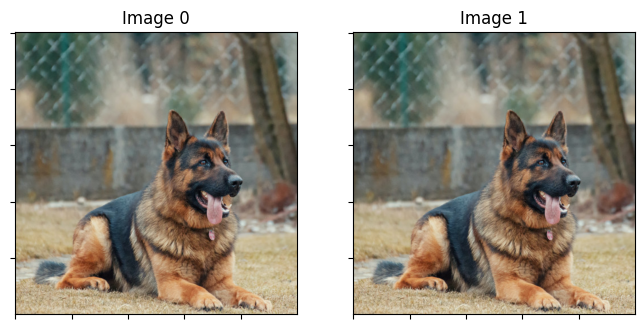

In [2]:
standardized_image = image / 255
plot(image, standardized_image)

To normalize an image, we look at the entire _training_ dataset and compute:
- the mean $\mu_R$ and standard deviation $\sigma_R$ of the red channel
- the mean $\mu_G$ and standard deviation $\sigma_G$ of the green channel
- the mean $\mu_B$ and standard deviation $\sigma_B$ of the blue channel

with which we can compute the z-scores for each pixel in each channel. If $x_{cij}$ is the pixel in channel $c$, row $i$, and column $j$, the corresponding output pixel after normalization will be $$z_{cij} = \frac{x_{cij}-\mu_c}{\sigma_c}$$

Luckily the `torchvision` package handles this transformation for us!

**NOTE**: In the code below, the normalization assumes that the image is already standardized. This is necessary as z-scores can be any real number.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


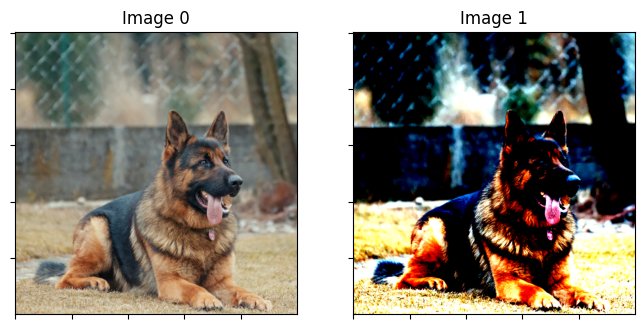

In [3]:
import torchvision.transforms.v2 as v2

# this mean and standard deviation is found from the ImageNet dataset
# in practice you'd have to find the mean and standard deviation for your own dataset (like the RvF dataset)
normalizer = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
normalized_image = normalizer(standardized_image.to(torch.float32))
plot(image, normalized_image)

We see some difference in the images now as some pixels become negative after computing the z-score. That said, note how the original structure is preserved - this is more critical for allowing our machine learning algorithm to learn.

Here is some theory if you're interested - but it's not at all needed to work on this project.

> Training neural networks (and machine learning models in general) use iterative descent methods like [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) to minimize a loss heuristic. These methods use local approximators (such as the [gradient](https://en.wikipedia.org/wiki/Gradient) of a multivariate surface) to determine which direction to move in to minimize the loss function. This leads to two major challenges, both of which can be solved through either standardization or normalization
> - If features are on different scales, then some parts of the loss surface will be steeper than others (see contour plot below). As gradient descent uses a single learning rate across all features, it is more likely to overshoot minima along features which have steeper slopes along the loss surface than for features which have flatter slopes along the loss surface. ![](https://i.stack.imgur.com/5jBJL.png)
> - If features are large, then the magnitude of the gradient is larger. This may cause the descent algorithm to overshoot minima of the loss function. It is better in this situation to have smaller features with a larger learning rate (as the learning rate can be tuned more easily).



It is important to note - other methods have been used to mitigate some of maleffects of gradient descent here. For example - Adam is designed to have different learning rates per each feature, thus avoiding the issue in the first bullet point.

### Data Augmentation

Data augmentation is a image preprocessing step that is used to combat **overfitting** in a convolutional neural network (and more generally any image based machine learning model).

We'll discuss overfitting in depth next week, but for now let's motivate what it means for a model to overfit.

Consider the case study from [this popular research paper](https://arxiv.org/pdf/1807.04975.pdf). In the paper, the researchers trained a computer vision model to recognize entities (such as a cow 🐮).

The authors then tried to extend their model to novel situations - such as identifying a cow on the beach (🐮 🏝️). For each of 3 situations, the authors, compared the top 5 most likely classes as per the model's predictions, and reported the results below (image reproduced from Figure 1 in paper).

![Image of machine learning model training results for a cow in a pasture vs a cow on a beach.](https://miro.medium.com/v2/resize:fit:1400/0*EWVAp3dh3d5YwsGn.png)

The figure above shows a clear trend:
- for cows that appear in pastures, which is a common scenario, the model is very confident that the image contains a cow (99% confident)
- for cows that appear on a beach, the model has no clue that the image contains a cow

Why is this happening? **Overfitting**! The model in paper was trained _only_ on data that contained cows on pastures (as most cows usually do live on pastures). However as a result, the model learned to associate _pastures_ with _cows_ - which is a noisy trend! While cows may certainly tend to live on pastures, a cow need not live on a pasture to be a cow.

In other words, the model fit _too closely_ to noisy patterns in the training dataset (the presence of pastures for cows) and learned relationships that didn't generalize well to new data (like cows on the beach). We'd like to avoid such behaviors in our models since it prevents our model from predicting unseen data correctly - which is why we want to tackle overfitting.

**KEY 🔑**: It's easy to write this off as a strange edge case, but overfitting tends to be _extremely common_ for models with high complexity (which we say have  **high variance**) - such as convolutional neural networks. These are really powerful models that very easily overfit to training data unless you have particularly clean data.

------

So how do we prevent overfitting? There are multiple solutions (many of which we'll discuss next week), but one way is to create a dataset that has fewer noisy trends. One way to do so is to _augment_ the data in such a way as to mitigate noisy trends. We call this **data augmentation**.

The sections below will list a few popular data augmentation methods that you may consider. That said, there are _tons_ of potential data augmentations you should explore [here](https://pytorch.org/vision/stable/transforms.html#v2-api-reference-recommended).

#### Random Crop

This method involves randomly cropping subsets of the image. If you suspect that your model is learning a position bias (where an object being in a certain part of an image is influencing your prediction), cropping can help.

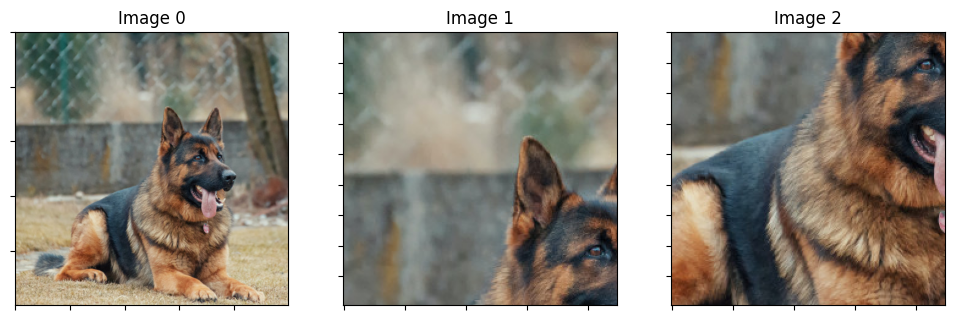

In [4]:
cropper = v2.RandomCrop(size=(224, 224))
plot(image, cropper(image), cropper(image))

Note how different calls to the `cropper` function lead to different parts of the image being cropped. This randomness in the cropping makes it harder for a model trained on this data to overfit to location information in the image. As it's harder to overfit to location information, the model can ideally learn more generic patterns in the image that correspond to the class we want.

#### Random Jitter

Similar to random cropping, random jitter randomly shifts the color of each pixel in an image. Random jitter may be useful when you suspect that your model is overfitting to noisy color trends.

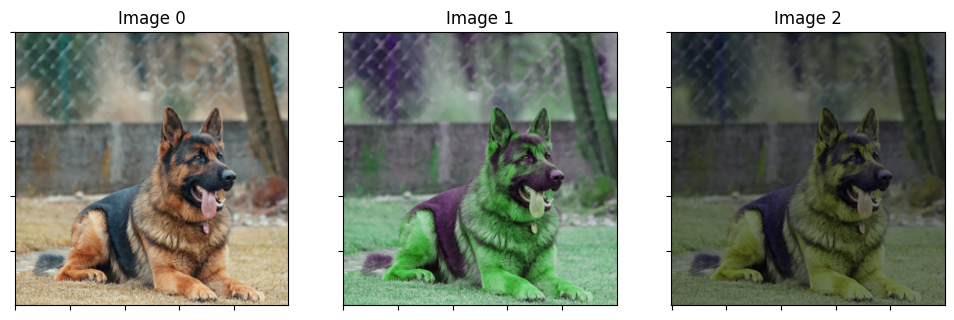

In [5]:
jitter = v2.ColorJitter(brightness=.5, hue=.3)
plot(image, jitter(image), jitter(image))

#### Gaussian Blur

Gaussian Blur adds blur to the image. This can be useful to smooth out image features and "simplify" the image.

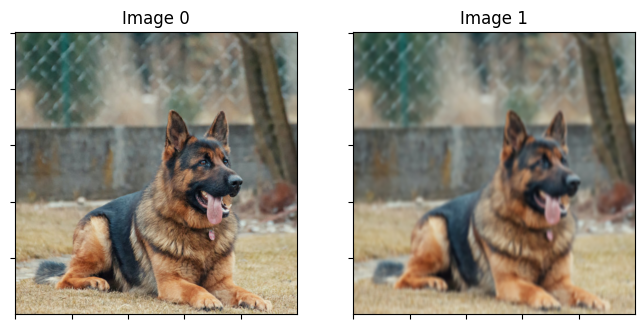

In [6]:
blurrer = v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.))
plot(image, blurrer(image))

#### Random Horizontal and Vertical Flip

Random Horizontal and Vertical Flip flip the input image randomly with some probability. Like random cropping, this can help if you think your model is learning to overfit to the position of certain patterns in the image.

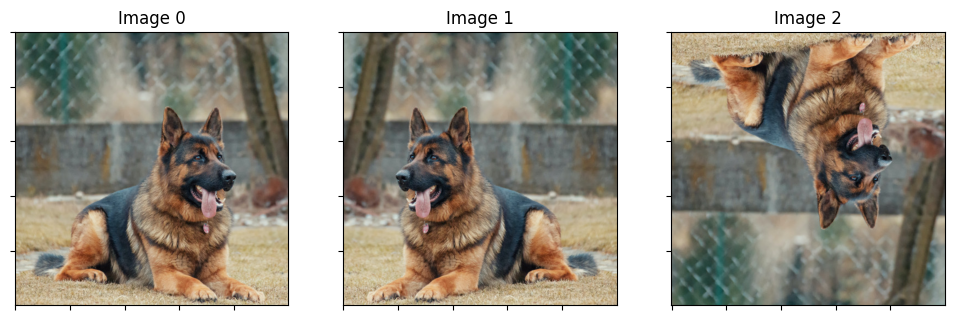

In [7]:
hflipper = v2.RandomHorizontalFlip(p=1)
vflipper = v2.RandomVerticalFlip(p=1)
plot(image, hflipper(image), vflipper(image))

### Feature Selection

Feature selections method are less common in modern computer vision due to properties of CNNs, but are certainly worth trying! In these methods, we will explicitly define ways to focus on certain subsets of pixels of the original image so our model can use specific extra information.

#### Edge Detection

Edge detection is a method that isolates all the _edges_ in an image. Intuitively, edges contain lots of useful identifying information in an image - isolating this can potentially help our model make more accurate predictions.

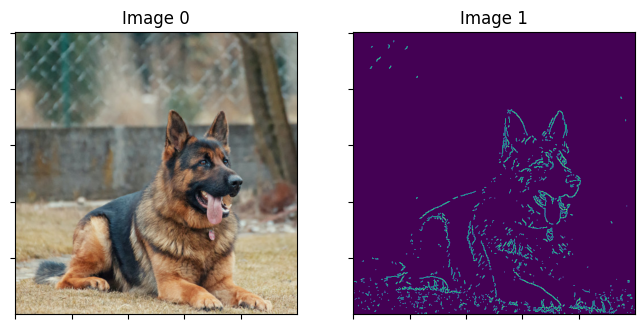

In [9]:
import cv2

tight = torch.from_numpy(cv2.Canny(image.permute(1,2,0).numpy(), 240, 250)).view(1, 500, 500)
plot(image, tight)

As we see, the image on the right contains the image of the dog, but with only the edges isolated.

## Implementing Preprocessing Methods

This section will focus on _how_ image preprocessing is implemented when training a convolutional neural network. For this section, you may want to review the [Custom Dataset Walkthrough](https://github.com/MichiganDataScienceTeam/W24-RvF/blob/main/notebooks/dataset.ipynb).

### CIFAR-10 Example

In most cases, image preprocessing in PyTorch is done inside the `Dataset` class by a dedicated preprocess function.

As an example, let's walkthrough creating an image preprocessing function for the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

In [ ]:
from torchvision import datasets

train_dataset = datasets.CIFAR10(root="./private", train=True, download=True, transform=None)

Notice how the dataset above has `transform=None`. This tells PyTorch that there should be no preprocessing applied. However let's say we _do_ want to apply some preprocessing transformations:
1. Normalize the images using the per-channel mean and standard deviation
2. Apply Random cropping and Gaussian Blur to each image returned

The first step in this process is calculating the per-channel mean and standard deviation. The code below will do that:

In [ ]:
mean = torch.zeros((3,))
variance = torch.zeros((3,))
tensor_converter = v2.ToTensor()

for image, _ in train_dataset:
    mean += tensor_converter(image).mean(dim=(1, 2))
mean /= len(train_dataset)

In [ ]:
for image, _ in train_dataset:
    image = tensor_converter(image)
    variance += ((image - mean.view(3, 1, 1))**2).mean(dim=(1,2))

std = torch.sqrt(variance / len(train_dataset))

In [ ]:
mean, std

Now we can create our preprocessor! This can be created using `torchvision.transforms.Compose`

In [ ]:
def add_edge_features(image):
    tight = torch.from_numpy(cv2.Canny(image.permute(1,2,0).numpy(), 240, 250)).view(1, 500, 500)
    return torch.dstack([image, tight]) # Add an extra channel for edges


tensor_converter = v2.Compose([ # Step 0: Convert from PIL Image to Torch Tensor
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])
normalizer = v2.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2532, 0.2496, 0.2681]) # Step 1. Normalize the image
cropper = v2.RandomCrop(size=(28, 28))
blurrer = v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.))

preprocessor = v2.Compose([
    tensor_converter,
    normalizer,
    cropper,
    blurrer
])

We can now recreate our dataset with this preprocessor function applied.

In [ ]:
train_dataset = datasets.CIFAR10(root="./private", train=True, download=True, transform=preprocessor)

If we try and view a few images now, we will see that they have been preprocessed as expected!

In [ ]:
plot(train_dataset[0][0], train_dataset[0][0], train_dataset[0][0])

## Next Steps

Now it's your turn! Experiment with different preprocessing steps with the RvF dataset and see what preprocessing steps lead to the best model performance!

If you are using the [starter code](https://github.com/MichiganDataScienceTeam/W24-RvF/tree/main/starter_code), you can specify your preprocessor as an input to the `get_loaders()` function. See the starter code [workbook](https://github.com/MichiganDataScienceTeam/W24-RvF/blob/main/starter_code/workbook.ipynb) for an example.